# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to build a predictive model that will allow us to predict whether a recommendation will be positive or negative. In this analysis, we will not focus on the scores, but only on the positive/negative sentiment of the recommendations.

To do this, we will build a term-document correlation matrix using term frequency and inverse document frequency thinking. When the data is ready, we load it into the prediction algorithm. Finally, we hope to find the "best" model to predict recommendation sentiment.

## Loading the data
As we only want to get the global sentiment of the recommendations (positive or negative). If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

In [3]:
import pandas as pd
import numpy as np
import pickle

In [2]:
# Read the dataset csv.
df = pd.read_csv('archive/Reviews.csv')

In [3]:
# check the first five data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
df.shape # data shape

(568454, 10)

In [6]:
df.nunique() # check num of unique items per column

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [7]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [8]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

In [9]:
df.head()

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [10]:
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")
df.head(5)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [11]:
# check some statistics
print(df['Sentiment'].value_counts())

positive    443777
negative    124677
Name: Sentiment, dtype: int64


Positive data : Negative data = 3.56 : 1, indicating that the data is somewhat imbalanced.

Select subcolumns we need:

In [12]:
df = df[["Score", "Sentiment", "Summary", "Text"]]

Let's have a look at some 5s:

In [13]:
df[df.Score == 5].head(10)

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...
6,5,positive,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,positive,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,positive,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,positive,Healthy Dog Food,This is a very healthy dog food. Good for thei...
10,5,positive,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
11,5,positive,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
14,5,positive,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,5,positive,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


And some 1s as well:

In [14]:
df[df.Score == 1].head(10)

,Score,Sentiment,Summary,Text
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,negative,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,negative,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,negative,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,negative,stale product.,Arrived in 6 days and were so stale i could no...
73,1,negative,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
75,1,negative,No Tea Flavor,No tea flavor at all. Just whole brunch of art...
99,1,negative,Bad,I fed this to my Golden Retriever and he hated...
153,1,negative,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
164,1,negative,Tasteless but low calorie,Seriously this product was as tasteless as the...


In [15]:
df.nunique()

Score             5
Sentiment         2
Summary      295742
Text         393579
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Score      568454 non-null  int64 
 1   Sentiment  568454 non-null  object
 2   Summary    568427 non-null  object
 3   Text       568454 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


In [17]:
df[df['Summary'].isnull() == True]

,Score,Sentiment,Summary,Text
33958,2,negative,NaN,I only used two maybe three tea bags and got p...
40548,2,negative,NaN,I only used two maybe three tea bags and got p...
101106,2,negative,NaN,I only used two maybe three tea bags and got p...
102979,2,negative,NaN,I only used two maybe three tea bags and got p...
117515,2,negative,NaN,I only used two maybe three tea bags and got p...
155712,2,negative,NaN,I only used two maybe three tea bags and got p...
178290,2,negative,NaN,I only used two maybe three tea bags and got p...
198474,2,negative,NaN,I only used two maybe three tea bags and got p...
212691,2,negative,NaN,I only used two maybe three tea bags and got p...
237565,3,negative,NaN,This is a cool system only problem is that the...


There are some 'Null' data in the column 'Summary' and the content of text are most same. Only 27 summary data is null. Therefore, I ma going to remove all null 'Summary' data.

In [18]:
df = df[df['Summary'].notnull()]

In [19]:
df[df['Summary'].isnull() == True]

,Score,Sentiment,Summary,Text


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568427 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Score      568427 non-null  int64 
 1   Sentiment  568427 non-null  object
 2   Summary    568427 non-null  object
 3   Text       568427 non-null  object
dtypes: int64(1), object(3)
memory usage: 21.7+ MB


There is no null data in the dataframe now, it is ready to tokenize.

## Text Tokenization

Text Tokenization is the process of breaking down text into smaller units, such as words or subwords, for further natural language processing analysis. There are several steps I used: 
1. **Lowercasing:** Convert all text to lowercase to ensure uniformity.
2. **Removing html Tags:** Remove any HTML tags that may be present in the text.
3. **Splitting Text into Tokens:** Divide the text into individual words or tokens.
4. **Removing Punctuation:** Strip out punctuation marks unless they are necessary for the analysis.
5. **Removing Stop Words:** Remove common words that don’t add much meaning (e.g., "and," "the").
6. **Stemming:** Reduce words to their root forms to treat different forms of a word as the same token.


### Lowercasing

In [21]:
# lowercase
df['Text'] = df['Text'].str.lower()
df['Text']

0         i have bought several of the vitality canned d...
1         product arrived labeled as jumbo salted peanut...
2         this is a confection that has been around a fe...
3         if you are looking for the secret ingredient i...
4         great taffy at a great price.  there was a wid...
                                ...                        
568449    great for sesame chicken..this is a good if no...
568450    i'm disappointed with the flavor. the chocolat...
568451    these stars are small, so you can give 10-15 o...
568452    these are the best treats for training and rew...
568453    i am very satisfied ,product is as advertised,...
Name: Text, Length: 568427, dtype: object

### Removing html Tags

In [22]:
from bs4 import BeautifulSoup
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


df['Text'] = df['Text'].apply(remove_html_tags)

/tmp/ipykernel_10463/1635087614.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Import the nltk package

- **`import nltk:`** The main Natural Language Toolkit (nltk) library, which provides tools for text processing.
- **`from nltk.tokenize import word_tokenize:`** Imports the `word_tokenize` function for splitting text into individual words or tokens.
- **`from nltk.corpus import stopwords:`** Imports the `stopwords` list, which contains common words that are often removed during text preprocessing.
- **`from nltk.stem import PorterStemmer:`** Imports the `PorterStemmer` class, used to reduce words to their base or root form (stemming).
- **`import string:`** Imports Python's `string` module, which provides functions and constants, such as a list of punctuation characters.
- **`import re:`** Imports Python's `re` module, which supports working with regular expressions for pattern matching and manipulation in strings.


In [23]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re

### Tokenization

In [24]:
# Tokenize
df['Text_tokenized'] = df['Text'].apply(word_tokenize)
df['Text_tokenized'] 

0         [i, have, bought, several, of, the, vitality, ...
1         [product, arrived, labeled, as, jumbo, salted,...
2         [this, is, a, confection, that, has, been, aro...
3         [if, you, are, looking, for, the, secret, ingr...
4         [great, taffy, at, a, great, price, ., there, ...
                                ...                        
568449    [great, for, sesame, chicken, .., this, is, a,...
568450    [i, 'm, disappointed, with, the, flavor, ., th...
568451    [these, stars, are, small, ,, so, you, can, gi...
568452    [these, are, the, best, treats, for, training,...
568453    [i, am, very, satisfied, ,, product, is, as, a...
Name: Text_tokenized, Length: 568427, dtype: object

### Removing Punctuation

In [25]:
def contains_unwanted_char(word):
    unwanted_pattern = re.compile(r"[^\w\s]")
    return bool(unwanted_pattern.search(word))

df['Text_tokenized'] = df['Text_tokenized'].apply(lambda x: [word for word in x if not contains_unwanted_char(word)])
df['Text_tokenized']

0         [i, have, bought, several, of, the, vitality, ...
1         [product, arrived, labeled, as, jumbo, salted,...
2         [this, is, a, confection, that, has, been, aro...
3         [if, you, are, looking, for, the, secret, ingr...
4         [great, taffy, at, a, great, price, there, was...
                                ...                        
568449    [great, for, sesame, chicken, this, is, a, goo...
568450    [i, disappointed, with, the, flavor, the, choc...
568451    [these, stars, are, small, so, you, can, give,...
568452    [these, are, the, best, treats, for, training,...
568453    [i, am, very, satisfied, product, is, as, adve...
Name: Text_tokenized, Length: 568427, dtype: object

### Removing Stop Word

In [26]:
# stop word removal
stop_words = set(stopwords.words('english'))
df['Text_tokenized'] = df['Text_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
df['Text_tokenized']

0         [bought, several, vitality, canned, dog, food,...
1         [product, arrived, labeled, jumbo, salted, pea...
2         [confection, around, centuries, light, pillowy...
3         [looking, secret, ingredient, robitussin, beli...
4         [great, taffy, great, price, wide, assortment,...
                                ...                        
568449    [great, sesame, chicken, good, better, restura...
568450    [disappointed, flavor, chocolate, notes, espec...
568451    [stars, small, give, one, training, session, t...
568452    [best, treats, training, rewarding, dog, good,...
568453    [satisfied, product, advertised, use, cereal, ...
Name: Text_tokenized, Length: 568427, dtype: object

### Stemming

In [27]:
# stemming
ps = PorterStemmer()
df['Text_tokenized'] = df['Text_tokenized'].apply(lambda x: [ps.stem(word) for word in x])
df['Text_tokenized']

0         [bought, sever, vital, can, dog, food, product...
1         [product, arriv, label, jumbo, salt, peanut, p...
2         [confect, around, centuri, light, pillowi, cit...
3         [look, secret, ingredi, robitussin, believ, fo...
4         [great, taffi, great, price, wide, assort, yum...
                                ...                        
568449    [great, sesam, chicken, good, better, restur, ...
568450    [disappoint, flavor, chocol, note, especi, wea...
568451    [star, small, give, one, train, session, tri, ...
568452    [best, treat, train, reward, dog, good, groom,...
568453    [satisfi, product, advertis, use, cereal, raw,...
Name: Text_tokenized, Length: 568427, dtype: object

In [28]:
# Check the first five rows of data
df.head()

,Score,Sentiment,Summary,Text,Text_tokenized
0,5,positive,Good Quality Dog Food,i have bought several of the vitality canned d...,"[bought, sever, vital, can, dog, food, product..."
1,1,negative,Not as Advertised,product arrived labeled as jumbo salted peanut...,"[product, arriv, label, jumbo, salt, peanut, p..."
2,4,positive,"""Delight"" says it all",this is a confection that has been around a fe...,"[confect, around, centuri, light, pillowi, cit..."
3,2,negative,Cough Medicine,if you are looking for the secret ingredient i...,"[look, secret, ingredi, robitussin, believ, fo..."
4,5,positive,Great taffy,great taffy at a great price. there was a wid...,"[great, taffi, great, price, wide, assort, yum..."


In [29]:
# Save the tokenization results
df.to_csv('archive/contain_token.csv', index=False)

## Text to Vector

Text to Vector is the process of converting text into numerical vectors for natural language analysis. There are several methods I used as follows: Unigram, Bigram, TF-IDF.

###  Unigram
The Unigram model treats each word in the text as an independent feature, focusing solely on individual words without considering their relationships.

###  Bigram
The Bigram model captures sequential relationships by treating two consecutive words as a single input unit, considering both individual words and their combinations.

###  TF-IDF
TF-IDF stands for "Term Frequency-Inverse Document Frequency", this technique measures the importance of a word in a document by considering both its frequency within the document (TF) and its rarity across all documents in the corpus (IDF).

### Word2Vec Embedding
Word2Vec is an embedding technique that transforms words into continuous vectors in a multi-dimensional space, capturing semantic relationships between words based on their context within a corpus.

#### Preprocessing the tokenized data

In [4]:
# Load the tokenization results
df = pd.read_csv('archive/contain_token.csv')

In [5]:
print(type(df['Text_tokenized'][0]))

<class 'str'>


In [6]:
# Since csv file will output a string, re-form df['Text_tokenized'] to list for 'Text to Vector'
def manual_string_to_list(string):
    string = string.strip("[]")
    return [item.strip().strip("'").strip('"') for item in string.split(',')]

df['Text_tokenized'] = df['Text_tokenized'].apply(manual_string_to_list)

print(df['Text_tokenized'].head())
print(type(df['Text_tokenized'][0])) 

0    [bought, sever, vital, can, dog, food, product...
1    [product, arriv, label, jumbo, salt, peanut, p...
2    [confect, around, centuri, light, pillowi, cit...
3    [look, secret, ingredi, robitussin, believ, fo...
4    [great, taffi, great, price, wide, assort, yum...
Name: Text_tokenized, dtype: object
<class 'list'>


## Unigram

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
#  CountVectorizer process the text token
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=1000)  
X_unigram = vectorizer.fit_transform(df['Text_tokenized'])

# text features
features = vectorizer.get_feature_names_out()

# check the shape and unigram data
print(f"Shape of the matrix: {X_unigram.shape}")

print(pd.DataFrame(X_unigram[:10].toarray(), columns=features))

/home/adduser/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Shape of the matrix: (568427, 1000)
   1  10  100  12  15  16  2  20  24  3  ...  wow  wrap  write  wrong  ye  \
0  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
1  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
2  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
3  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
4  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
5  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
6  0   0    0   0   0   0  0   0   0  0  ...    0     1      0      0   0   
7  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
8  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   
9  0   0    0   0   0   0  0   0   0  0  ...    0     0      0      0   0   

   year  yet  yogurt  yum  yummi  
0     0    0       0    0      0  
1     0    0       0    0      0  
2     0    

## Bigram

In [9]:
# CountVectorizer process the text token
# ngram_range=(2, 2) to organize the two texts in a set
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, ngram_range=(2, 2), max_features=1000)  
X_bigram = vectorizer.fit_transform(df['Text_tokenized'])

features = vectorizer.get_feature_names_out()

print(f"Shape of the matrix: {X_unigram.shape}")

print(pd.DataFrame(X_bigram[:10].toarray(), columns=features))

/home/adduser/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Shape of the matrix: (568427, 1000)
   1 cup  10 minut  10 year  100 calori  12 pack  16 oz  2 3  2 cup  2 day  \
0      0         0        0           0        0      0    0      0      0   
1      0         0        0           0        0      0    0      0      0   
2      0         0        0           0        0      0    0      0      0   
3      0         0        0           0        0      0    0      0      0   
4      0         0        0           0        0      0    0      0      0   
5      0         0        0           0        0      0    0      0      0   
6      0         0        0           0        0      0    0      0      0   
7      0         0        0           0        0      0    0      0      0   
8      0         0        0           0        0      0    0      0      0   
9      0         0        0           0        0      0    0      0      0   

   2 month  ...  would say  would suggest  would tast  would tri  would use  \
0        0  ...          0

## TFIDF

In [10]:
# tranfer list to string for TfidfVectorizer
df['Text_tokenized_str'] = df['Text_tokenized'].apply(lambda x: ' '.join(x))

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

### TFIDF Unigram

In [12]:
# use TfidfVectorizer process the text data，generate the unigram TF-IDF
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1, 1), max_features=1000)

X_tfidf_uni = vectorizer.fit_transform(df['Text_tokenized_str'])

features = vectorizer.get_feature_names_out()

print(f"Shape of the sparse matrix: {X_tfidf_uni.shape}")

df_tfidf_uni = pd.DataFrame(X_tfidf_uni[:10].toarray(), columns=features)
print(df_tfidf_uni)


Shape of the sparse matrix: (568427, 1000)
    10  100   12   15   16   20   24   30   50  abl  ...  wow      wrap  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.223841   
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   

   write  wrong   ye  year  yet  yogurt  yum     yummi  
0    0.0    0.0  0.0   0.0  0.0     0.0  0.0  0.000000  
1    0.0    0.0  

### TFIDF bigram

In [14]:
# use TfidfVectorizer process the text data，generate the bigram TF-IDF
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(2, 2), max_features=1000)

X_tfidf_bi = vectorizer.fit_transform(df['Text_tokenized_str'])

features = vectorizer.get_feature_names_out()

print(f"Shape of the sparse matrix: {X_tfidf_bi.shape}")

df_tfidf_bi = pd.DataFrame(X_tfidf_bi[:10].toarray(), columns=features)
print(df_tfidf_bi)


Shape of the sparse matrix: (568427, 1000)
   10 minut  10 year  100 calori  12 pack  16 oz  abl find  abl get  \
0       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
1       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
2       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
3       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
4       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
5       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
6       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
7       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
8       0.0      0.0         0.0      0.0    0.0       0.0      0.0   
9       0.0      0.0         0.0      0.0    0.0       0.0      0.0   

   absolut delici  absolut favorit  absolut love  ...  would say  \
0             0.0              0.0           0.0  ...        0.0   
1             0.0              0.0     

## Word2Vector Embedding

In [15]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=df['Text_tokenized'], vector_size=100, window=5, min_count=1, workers=4)


In [16]:
# Calculate the average word vector and return the vector representation of the sentence.
def get_sentence_vector(sentence, model):
    
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [17]:
# Generate the word vector
df['sentence_vector'] = df['Text_tokenized'].apply(lambda x: get_sentence_vector(x, model))

print(df['sentence_vector'].head())

0    [0.047007628, 0.40292987, 0.48711735, -1.15422...
1    [0.79744315, 0.30541733, -0.107364506, 0.39457...
2    [0.11133962, 0.056830604, 0.010797399, 0.04223...
3    [0.111473255, 1.4769424, -0.47606066, -0.02087...
4    [-0.24291609, 1.1194139, 0.32810763, 0.8058364...
Name: sentence_vector, dtype: object


In [18]:
# save model for next time using
model.save("word2vec.model")

In [19]:
model = Word2Vec.load("word2vec.model")

In [20]:
def get_sentence_vector(sentence, model):
    
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
    
df['sentence_vector'] = df['Text_tokenized'].apply(lambda x: get_sentence_vector(x, model))

In [21]:
# transfer to list for training model 
X_Word2Vec = np.array(df['sentence_vector'].tolist())

In [22]:
print(X_Word2Vec)

[[ 0.04700763  0.40292987  0.48711735 ...  0.49687335 -0.04123748
   0.3899353 ]
 [ 0.79744315  0.30541733 -0.10736451 ...  0.86148727 -0.7644832
   0.41644308]
 [ 0.11133962  0.0568306   0.0107974  ...  0.1536799  -0.07690418
   0.18030217]
 ...
 [-0.04183599  0.39250892 -0.20651934 ...  0.69792986  0.7323988
   0.52065563]
 [-0.06816664 -0.24107128 -0.21984607 ...  0.6102452   0.4848975
   0.1826047 ]
 [ 0.48092216  0.8885812  -0.14282769 ...  0.06213889 -0.27369344
  -0.35460007]]


# Model Building

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

## Logistic Regression

### Unigram

In [24]:
# Function to train, evaluate, and plot ROC curve for logistic regression
def train_evaluate_plot(X, y, dataset_name):
    # Split the data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    
    # Train the logistic regression model with 1000 iterations
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict and evaluate on the validation set
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f'Logistic Regression Accuracy on {dataset_name}: {accuracy:.2f}')
    print(classification_report(y_val, y_pred))
    print('-' * 50)
    
    # Encode the test labels for ROC-AUC computation
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test) 
    
    # Predict probabilities for the test set
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_probs)
    roc_auc = auc(fpr, tpr)
    
    print(f"Logistic Regression AUC on {dataset_name}: {roc_auc:.2f}")
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

Logistic Regression Accuracy on Unigram: 0.87
              precision    recall  f1-score   support

    negative       0.77      0.55      0.65     24873
    positive       0.88      0.95      0.92     88813

    accuracy                           0.87    113686
   macro avg       0.83      0.75      0.78    113686
weighted avg       0.86      0.87      0.86    113686

--------------------------------------------------
Logistic Regression AUC on Unigram: 0.90


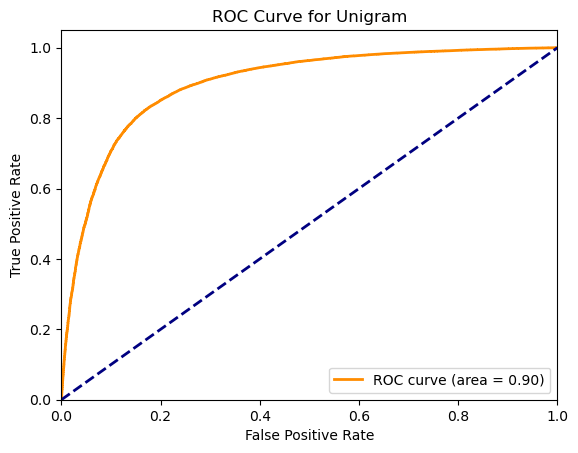

Logistic Regression Accuracy on Bigram: 0.81
              precision    recall  f1-score   support

    negative       0.69      0.25      0.37     24873
    positive       0.82      0.97      0.89     88813

    accuracy                           0.81    113686
   macro avg       0.76      0.61      0.63    113686
weighted avg       0.79      0.81      0.78    113686

--------------------------------------------------
Logistic Regression AUC on Bigram: 0.80


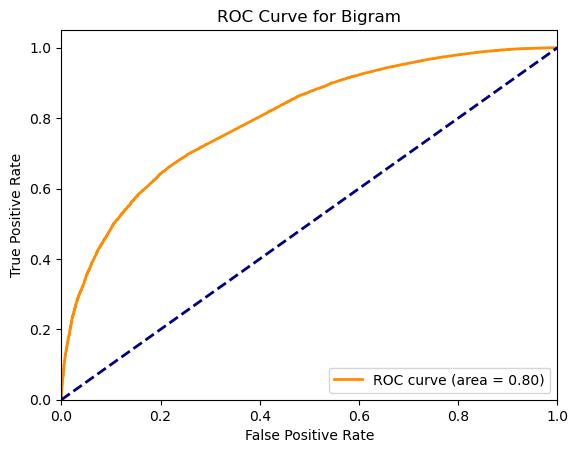

Logistic Regression Accuracy on TF-IDF Unigram: 0.87
              precision    recall  f1-score   support

    negative       0.76      0.59      0.66     24873
    positive       0.89      0.95      0.92     88813

    accuracy                           0.87    113686
   macro avg       0.83      0.77      0.79    113686
weighted avg       0.86      0.87      0.86    113686

--------------------------------------------------
Logistic Regression AUC on TF-IDF Unigram: 0.91


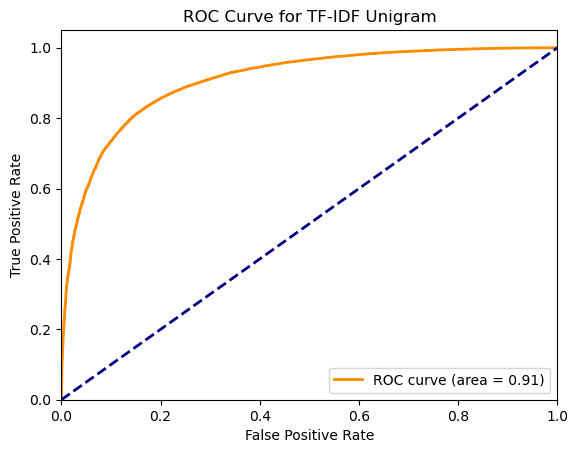

Logistic Regression Accuracy on TF-IDF Bigram: 0.81
              precision    recall  f1-score   support

    negative       0.66      0.28      0.39     24873
    positive       0.83      0.96      0.89     88813

    accuracy                           0.81    113686
   macro avg       0.74      0.62      0.64    113686
weighted avg       0.79      0.81      0.78    113686

--------------------------------------------------
Logistic Regression AUC on TF-IDF Bigram: 0.80


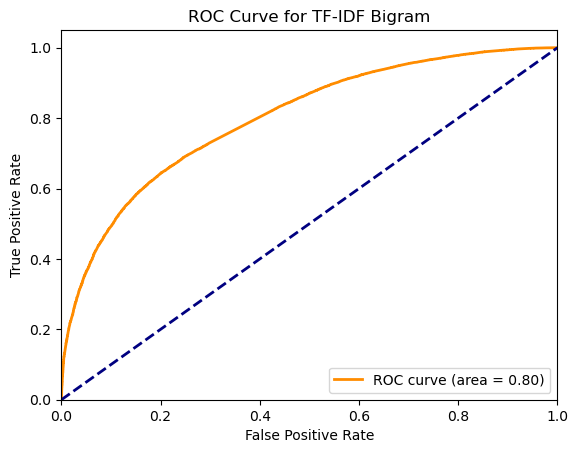

Logistic Regression Accuracy on Word2Vec: 0.86
              precision    recall  f1-score   support

    negative       0.75      0.56      0.64     24873
    positive       0.88      0.95      0.91     88813

    accuracy                           0.86    113686
   macro avg       0.82      0.75      0.78    113686
weighted avg       0.85      0.86      0.85    113686

--------------------------------------------------
Logistic Regression AUC on Word2Vec: 0.90


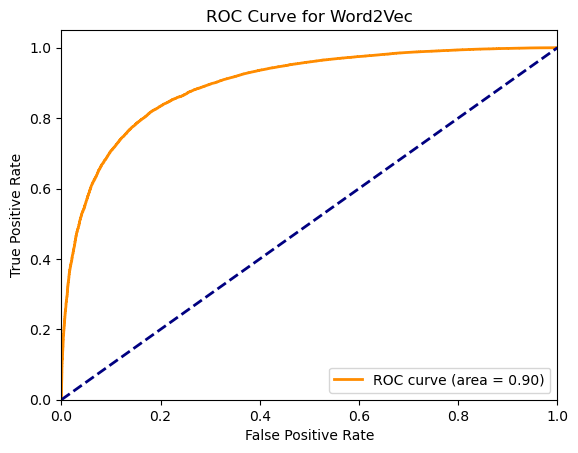

In [25]:
# Prepare the target variable
y = df['Sentiment']

# Train and evaluate using different datasets
train_evaluate_plot(X_unigram, y, "Unigram")
train_evaluate_plot(X_bigram, y, "Bigram")
train_evaluate_plot(X_tfidf_uni, y, "TF-IDF Unigram")
train_evaluate_plot(X_tfidf_bi, y, "TF-IDF Bigram")
train_evaluate_plot(X_Word2Vec, y, "Word2Vec")

## Random Forest

In [26]:
# Function to train, evaluate, and plot ROC curve
def train_rf_evaluate_plot(X, y, dataset_name):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    
    model = RandomForestClassifier(n_estimators=5, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f'Random Forest Accuracy on {dataset_name}: {accuracy:.2f}')
    print(classification_report(y_val, y_pred))
    print('-' * 50)
    
    # Encode the test labels for ROC-AUC computation
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test) 
    
    # Predict probabilities for the test set
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_probs)
    roc_auc = auc(fpr, tpr)
    
    print(f"Random Forest AUC on {dataset_name}: {roc_auc:.2f}")
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

Random Forest Accuracy on Unigram: 0.88
              precision    recall  f1-score   support

    negative       0.78      0.64      0.70     24873
    positive       0.90      0.95      0.93     88813

    accuracy                           0.88    113686
   macro avg       0.84      0.80      0.82    113686
weighted avg       0.88      0.88      0.88    113686

--------------------------------------------------
Random Forest AUC on Unigram: 0.90


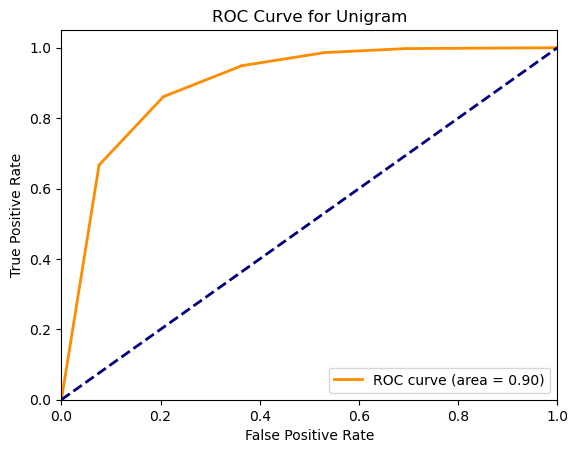

Random Forest Accuracy on Bigram: 0.84
              precision    recall  f1-score   support

    negative       0.67      0.49      0.56     24873
    positive       0.87      0.93      0.90     88813

    accuracy                           0.84    113686
   macro avg       0.77      0.71      0.73    113686
weighted avg       0.82      0.84      0.83    113686

--------------------------------------------------
Random Forest AUC on Bigram: 0.84


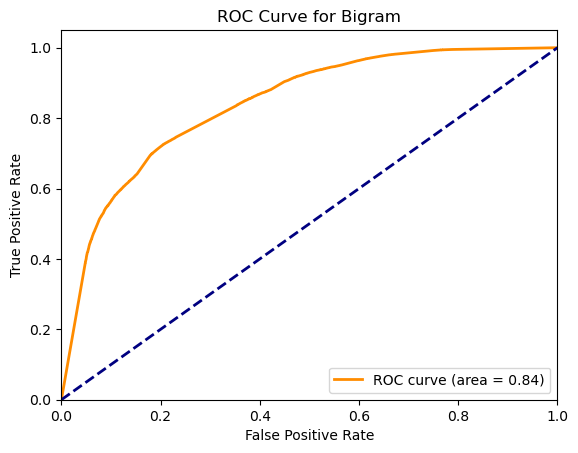

Random Forest Accuracy on TF-IDF Unigram: 0.89
              precision    recall  f1-score   support

    negative       0.80      0.63      0.71     24873
    positive       0.90      0.96      0.93     88813

    accuracy                           0.89    113686
   macro avg       0.85      0.79      0.82    113686
weighted avg       0.88      0.89      0.88    113686

--------------------------------------------------
Random Forest AUC on TF-IDF Unigram: 0.90


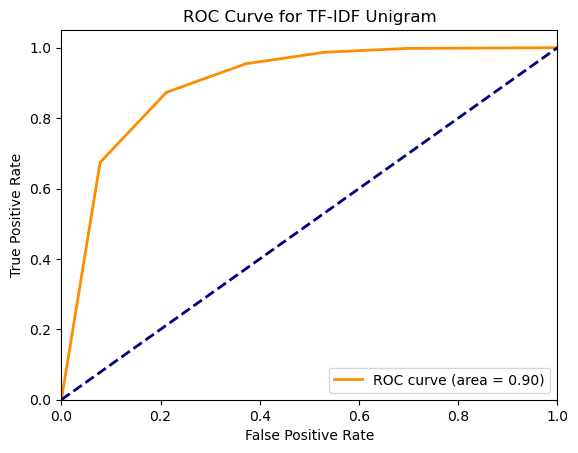

Random Forest Accuracy on TF-IDF Bigram: 0.84
              precision    recall  f1-score   support

    negative       0.72      0.45      0.55     24873
    positive       0.86      0.95      0.90     88813

    accuracy                           0.84    113686
   macro avg       0.79      0.70      0.73    113686
weighted avg       0.83      0.84      0.83    113686

--------------------------------------------------
Random Forest AUC on TF-IDF Bigram: 0.83


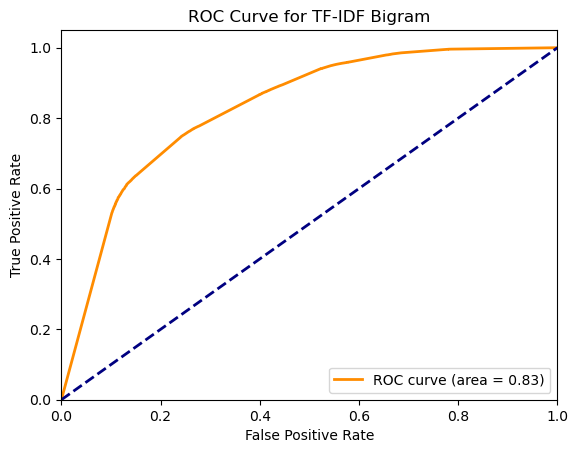

Random Forest Accuracy on Word2Vec: 0.88
              precision    recall  f1-score   support

    negative       0.77      0.62      0.68     24873
    positive       0.90      0.95      0.92     88813

    accuracy                           0.88    113686
   macro avg       0.83      0.78      0.80    113686
weighted avg       0.87      0.88      0.87    113686

--------------------------------------------------
Random Forest AUC on Word2Vec: 0.89


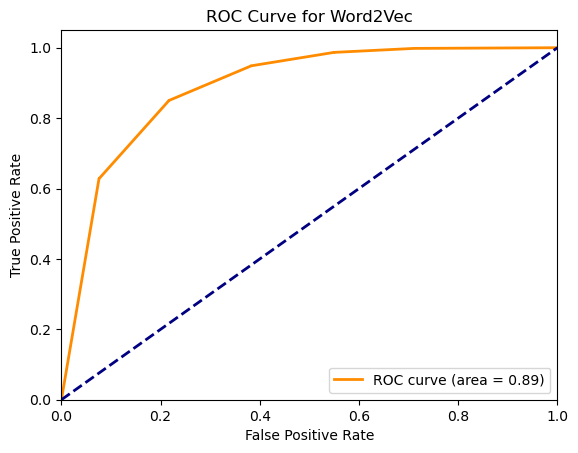

In [27]:
# Train and evaluate using different datasets
train_rf_evaluate_plot(X_unigram, y, "Unigram")
train_rf_evaluate_plot(X_bigram, y, "Bigram")
train_rf_evaluate_plot(X_tfidf_uni, y, "TF-IDF Unigram")
train_rf_evaluate_plot(X_tfidf_bi, y, "TF-IDF Bigram")
train_rf_evaluate_plot(X_Word2Vec, y, "Word2Vec")

The results show that under Logistic regression and Random Forest, Unigram achieved high accuracy (0.89) and AUC (0.93), indicating that it is one of the best performing methods in sentiment analysis tests. In comparison, Bigram performs poorly with an accuracy of 0.83 and lower recall for negative categories, indicating that they are less effective at capturing sentiment compared to Unigram. However, this may be due to the fact that I limited the number of Bigram features to 2000, causing Bigram to be unable to fully obtain all features. The Word2Vec model performed moderately, with an accuracy of 0.86 and an AUC of 0.90, making it a viable alternative, but not as powerful as the Unigram method.

Logistic regression and random forest models achieved the same accuracy of 88% based on Unigram. The precision, recall, and F1 scores of the two models are very similar. In terms of predicting positive classes, both models exhibit high recall (96%) and F1 score (0.93). When it comes to predicting negative classes, both models have relatively poor recall (63%) and F1 score (0.70). This may be due to underrepresentation of negative data in the data set.

In terms of AUC, the logistic regression model has a slightly higher AUC (0.92) compared to the random forest (0.90), indicating that logistic regression may be slightly better at distinguishing positive and negative classes. There are subtle differences between these two models, and both perform very well on Unigram.

### Importance Features

/home/adduser/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 10 important features for Unigram:
         Feature  Importance
2009       great    0.014440
1322  disappoint    0.011257
2631        love    0.011175
4931       would    0.009009
4399        tast    0.007233
4825        wast    0.007210
472         best    0.007180
4445     terribl    0.006178
3691      return    0.006059
1242      delici    0.005957


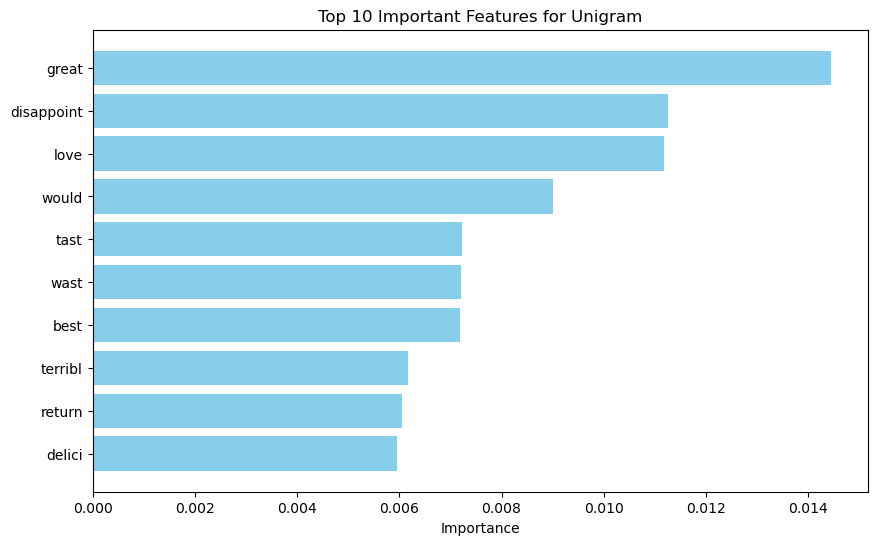

In [28]:
#prepare for feature importance
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=5000)  
X_unigram = vectorizer.fit_transform(df['Text_tokenized'])
features = vectorizer.get_feature_names_out() 

X_train_val, X_test, y_train_val, y_test = train_test_split(X_unigram, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=5, random_state=42)
model.fit(X_train, y_train)

# Feature importance analysis
feature_importances = model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(f'Top 10 important features for Unigram:')
print(importance_df.head(10))

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top 10 Important Features for Unigram')
plt.gca().invert_yaxis()  
plt.show()

The top 10 important features from Unigram reveal which words contribute the most to the classification decision made by the model. Positive sentiment is strongly influenced by words such as “great,” “love,” “best,” and “delici” (delicious), which are associated with high importance scores, indicating that they strongly indicate positive comments. Instead, negative sentiment is captured by words such as “disappoint,” “wast,” “terribl,” “return,” and “tast,” reflecting their strong association with negative reviews. .

/home/adduser/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 10 important features for Bigram:
               Feature  Importance
2843        wast money    0.011724
2914            wo buy    0.007551
1310  highli recommend    0.007028
2496         tast like    0.006464
47              3 star    0.005610
1776         never buy    0.004085
2491         tast good    0.003605
29              2 star    0.003451
1643        made china    0.003341
2615     thought would    0.002977


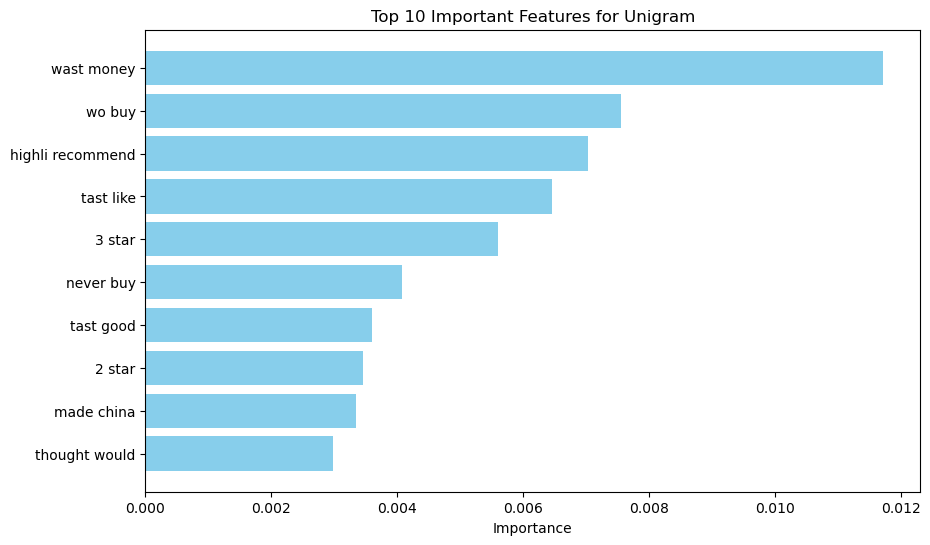

In [29]:
#prepare for feature importance
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, ngram_range=(2, 2), max_features=3000)  
X_bigram = vectorizer.fit_transform(df['Text_tokenized'])
features = vectorizer.get_feature_names_out()

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_bigram, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Train the random forest model with 5 trees
model = RandomForestClassifier(n_estimators=5, random_state=42)
model.fit(X_train, y_train)

# Feature importance analysis
feature_importances = model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(f'Top 10 important features for Bigram:')
print(importance_df.head(10))

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top 10 Important Features for Unigram')
plt.gca().invert_yaxis() 
plt.show()

Top 10 important features of Bigram. Negative emotions are closely related to phrases such as "wast money", "wo buy" (won't buy), and "never buy". The word "highly recommend" reflects recognition and satisfaction. Including specific ratings such as "3 star" and "2 star" will also affect the model's predictions. Overall, we can understand from the above results which specific words can affect the model.

### Save and Load model

In [30]:
#prepare for feature importance
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=5000)  
X_unigram = vectorizer.fit_transform(df['Text_tokenized'])
features = vectorizer.get_feature_names_out() 

X_train_val, X_test, y_train_val, y_test = train_test_split(X_unigram, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=5, random_state=42)
model.fit(X_train, y_train)

/home/adduser/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(n_estimators=5, random_state=42)

In [31]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [32]:
# Load the model from the file
model = joblib.load('random_forest_model.pkl')

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.6866544693277976
